# Exercises

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import numpy as np
import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import lfp_functions as lf
from scipy.signal import butter, filtfilt
import scipy.signal as signal
import pywt
from scipy.stats import zscore

## Exercise 1: explore filter parameters
---
In this exercises you will explore how different parameters affect the filtering process.
- Import the data form `data/moving_lfp.pickle` (the file is already on your machine if you run the `download_data()` cell in the main lesson)
- Take a few seconds of the data, and filter them in different frequency bands. Plot the resulting singal.
  Fix the central frequency and play with the width of the band, then try to change the central frequency of the band.
- Change the order of the filter, keeping the frequency band fixed. How does the filtered signal change? How does the computing time change? (You can try to quantify the computing time with the jupyter magic command [`%timeit`](https://docs.python.org/3/library/timeit.html) )
- Comment on what you see

In [2]:
with open('data/moving_lfp.pickle', 'rb') as handle:
    lfp_data = pickle.load(handle)

lfp = lfp_data['lfp']
sampling_rate = lfp_data['sampling_rate']
print(f'Loaded {len(lfp)/sampling_rate} seconds of LFP, sampled at {sampling_rate} Hz')

Loaded 600.133 seconds of LFP, sampled at 1000.0 Hz


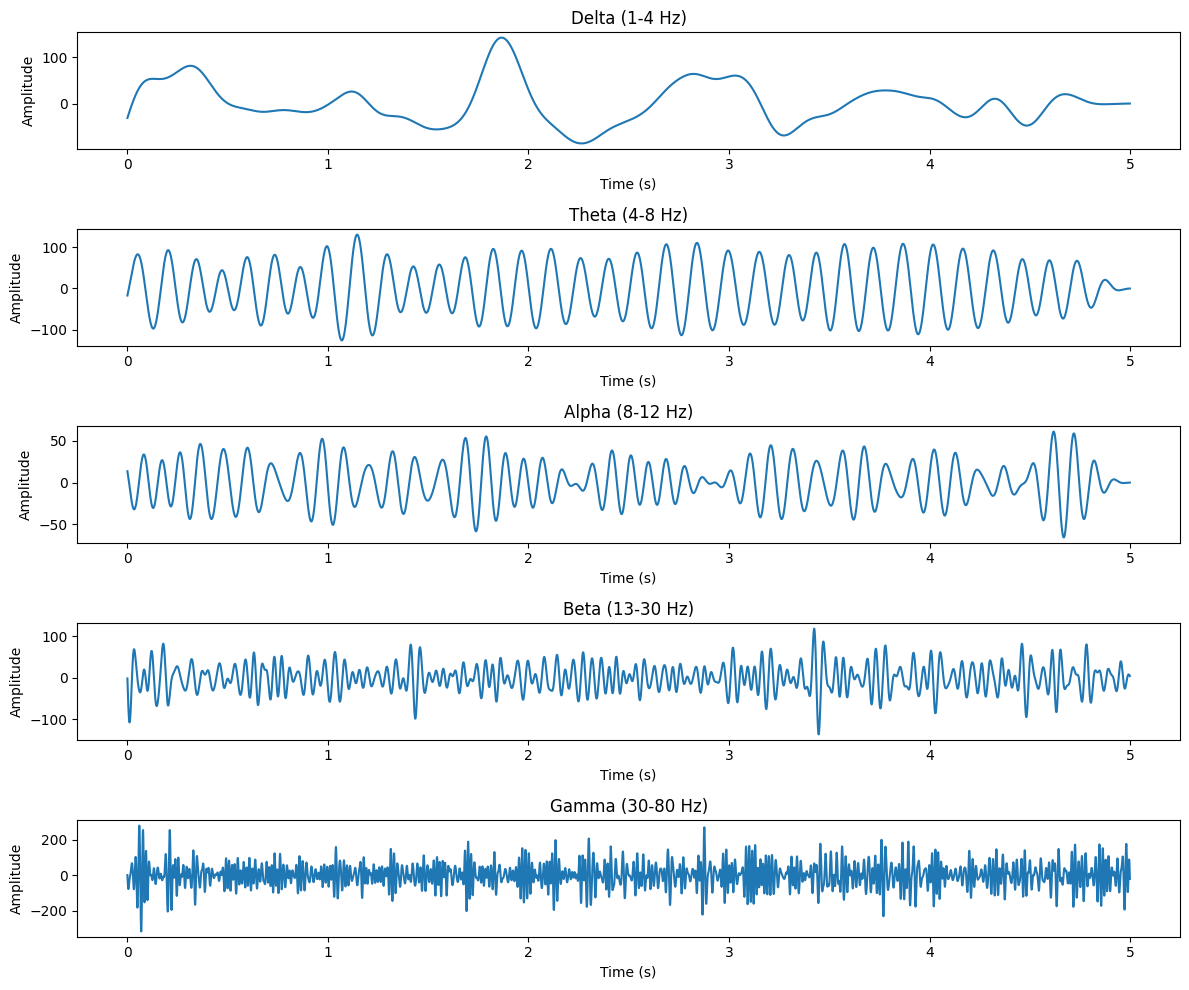

In [ ]:
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

duration = 5  #in seconds
start_index = 0
end_index = int(duration * sampling_rate)
segment = lfp[start_index:end_index]

frequency_bands = {
    'Delta (1-4 Hz)': (1, 4),
    'Theta (4-8 Hz)': (4, 8),
    'Alpha (8-12 Hz)': (8, 12),
    'Beta (13-30 Hz)': (13, 30),
    'Gamma (30-80 Hz)': (30, 80),
}

filtered_signals = {}
for band_name, (low, high) in frequency_bands.items():
    filtered_signals[band_name] = bandpass_filter(segment, low, high, sampling_rate)

plt.figure(figsize=(12, 10))
time = np.arange(len(segment)) / sampling_rate
for i, (band_name, signal) in enumerate(filtered_signals.items(), 1):
    plt.subplot(len(frequency_bands), 1, i)
    plt.plot(time, signal)
    plt.title(band_name)
    plt.ylabel('Amplitude')
    plt.xlabel('Time (s)')
    plt.tight_layout()
plt.show()


The Delta band (1–4 Hz) shows slow and smooth waves with large ups and downs. This is normal for very low frequencies, and these kinds of waves are often seen during deep sleep. The Theta band (4–8 Hz) has more waves than Delta and the waves are faster, but still smooth. These are often linked to light sleep or deep thinking. The Alpha band (8–12 Hz) shows a regular and faster rhythm, which is common when a person is relaxed but awake. The Beta band (13–30 Hz) has many fast waves close together, and the signal looks more active. These waves usually happen when someone is thinking or focusing. The Gamma band (30–80 Hz) has very fast and small waves that are packed tightly. This signal looks more complex and can be linked to high-level brain activity like attention or learning.

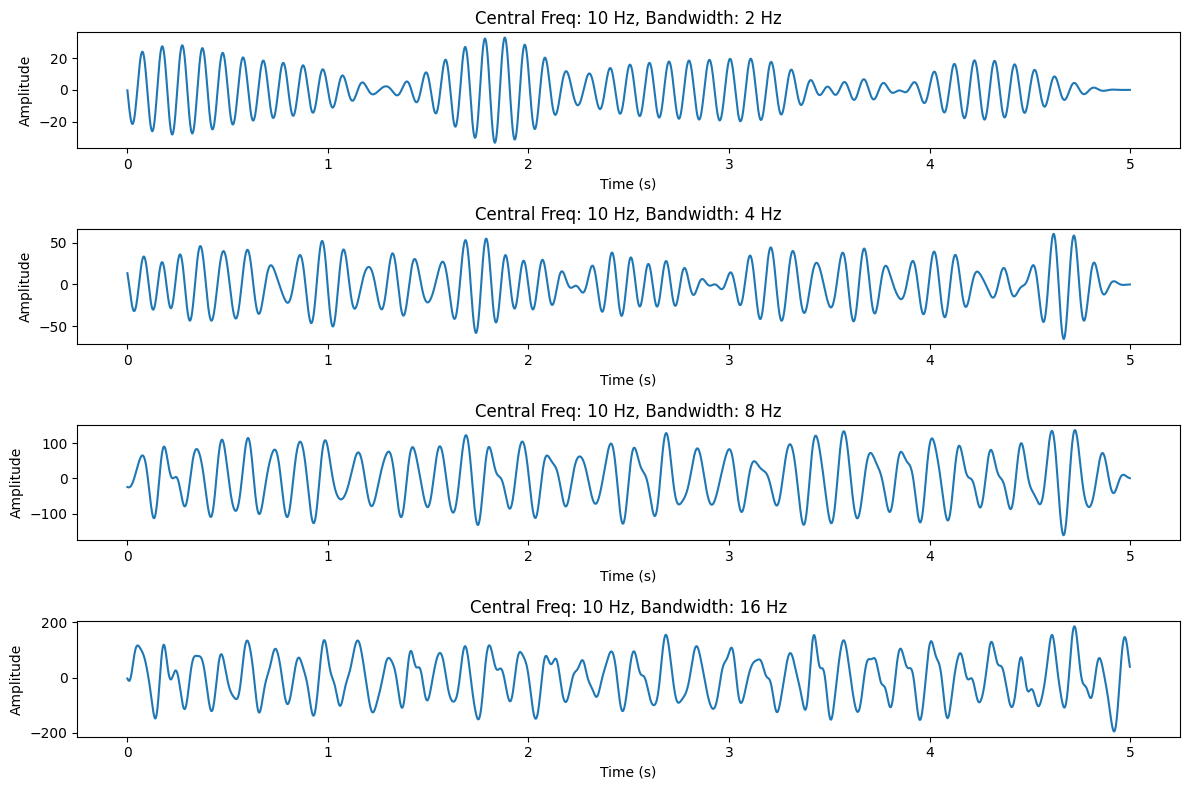

In [9]:
central_freq = 10  #fixed central frequency in Hz
bandwidths = [2, 4, 8, 16]  #different bandwidths

plt.figure(figsize=(12, 8))
time_array = np.arange(len(segment)) / sampling_rate

for i, bw in enumerate(bandwidths, 1):
    low = central_freq - bw / 2
    high = central_freq + bw / 2
    filtered = bandpass_filter(segment, low, high, sampling_rate)
    plt.subplot(len(bandwidths), 1, i)
    plt.plot(time_array, filtered)
    plt.title(f'Central Freq: {central_freq} Hz, Bandwidth: {bw} Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

The plots show how a brain signal looks when we keep the central frequency fixed at 10 Hz but change the width of the frequency band (called bandwidth). In the first plot, the bandwidth is narrow (2 Hz), so the signal looks very clean and regular, mostly showing the 10 Hz wave. As the bandwidth gets wider (4 Hz, 8 Hz, 16 Hz), more frequencies are allowed in, so the signal starts to look more complex and less smooth. It becomes less like a single wave and more mixed, with some high and low frequency parts. This shows that a narrow band keeps only the desired frequency, while a wider band includes more noise and extra signals around the target frequency.

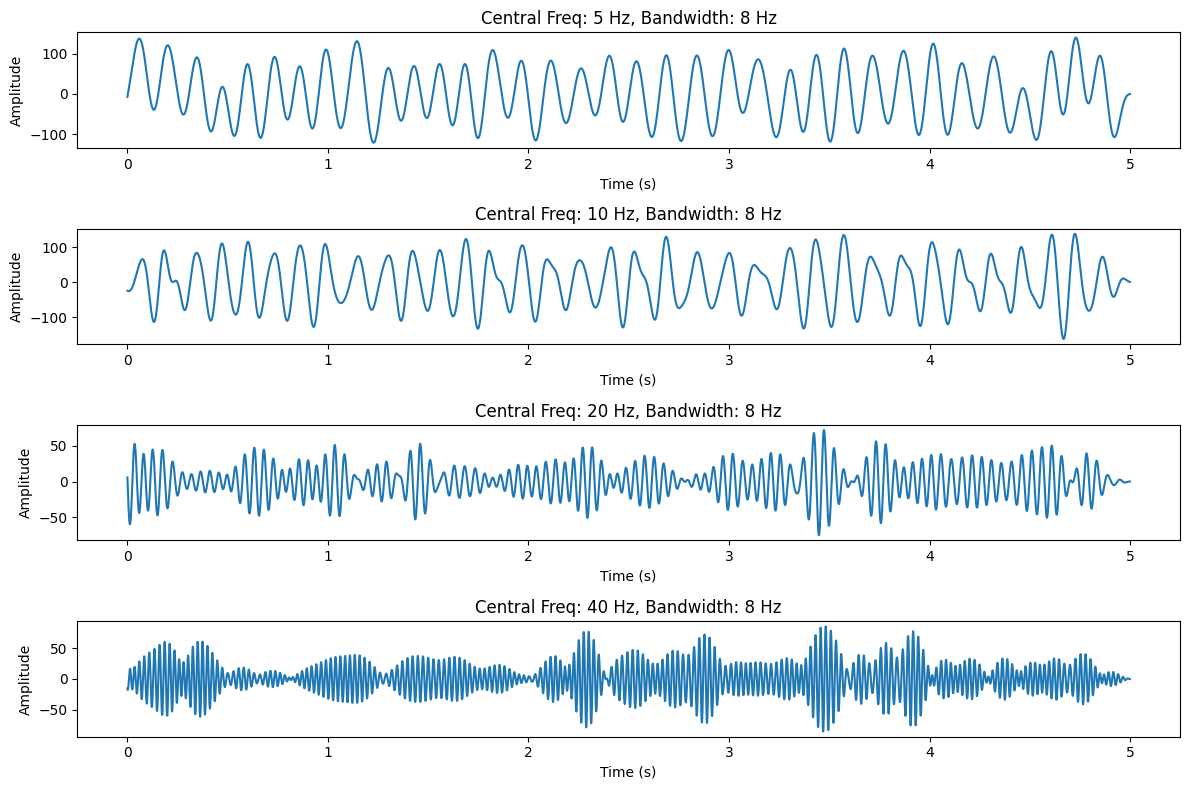

In [5]:
bandwidth = 8  #fixed bandwidth
central_freqs = [5, 10, 20, 40]  #different central frequencies

plt.figure(figsize=(12, 8))

for i, fc in enumerate(central_freqs, 1):
    low = fc - bandwidth / 2
    high = fc + bandwidth / 2
    filtered = bandpass_filter(segment, low, high, sampling_rate)
    plt.subplot(len(central_freqs), 1, i)
    plt.plot(time, filtered)
    plt.title(f'Central Freq: {fc} Hz, Bandwidth: {bandwidth} Hz')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


These plots show what happens when we keep the bandwidth fixed at 8 Hz and change the central frequency of the filter. At 5 Hz, the signal is slow and smooth, with fewer waves per second. At 10 Hz, the signal still looks fairly clean but has more cycles, faster than at 5 Hz. At 20 Hz, the wave becomes even faster and more complex, and some parts look stronger than others. At 40 Hz, the signal is much faster and looks very detailed with lots of quick ups and downs. As the central frequency increases, we can see faster and more detailed patterns in the signal. This shows that the central frequency decides the speed of the wave patterns we keep in the signal.

## Exercise 2: wavelet transform with real wavelets
---
In this exercises you will explore the difference between real and complex wavelets in the continous wavelet transform.
- Import the data form `data/moving_lfp.pickle`
- Select a period of a few seconds of the signal and compute the spectrogram. 
  Try the wavelet transform with wavelet `mexh` (mexican hat),`gaus` (gaussian) and `morl` (morlet). These are all real wavelets.
- What differences do you see with respect to the spectrum computed with the complex Morlet tranform ? Comment on why do you think this might be the case.

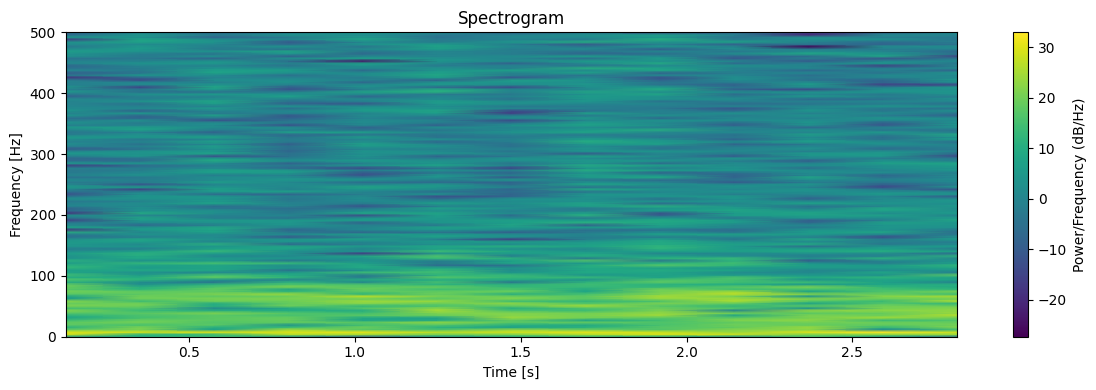

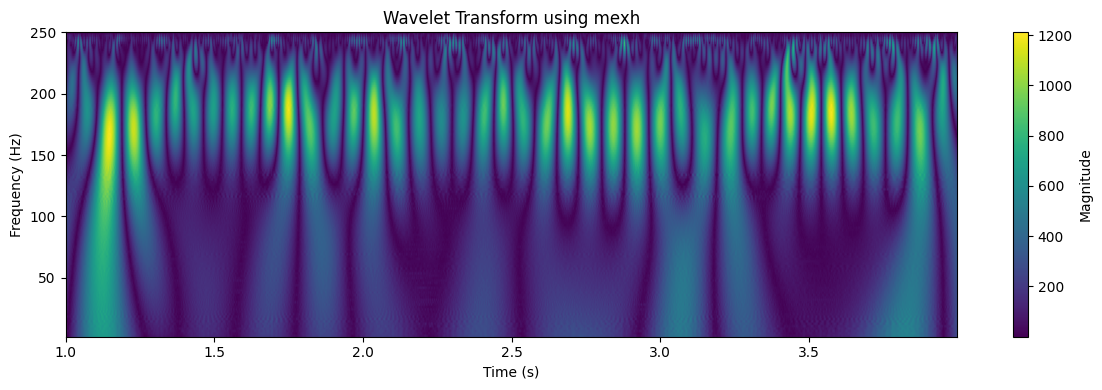

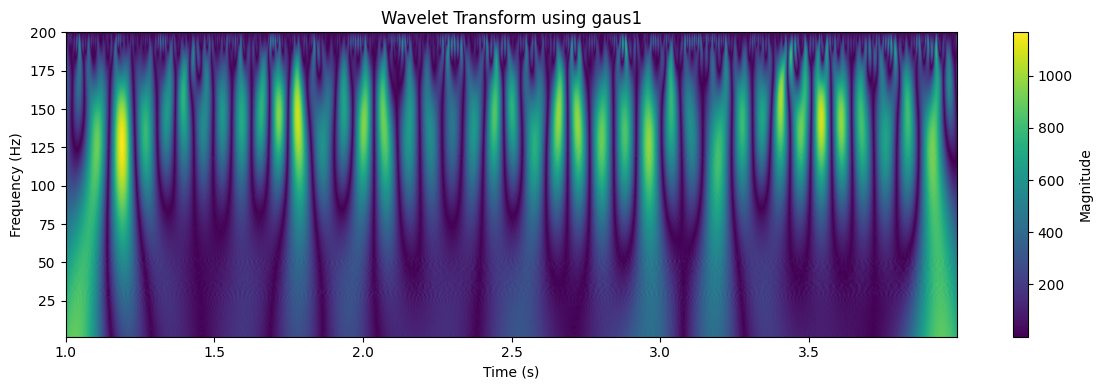

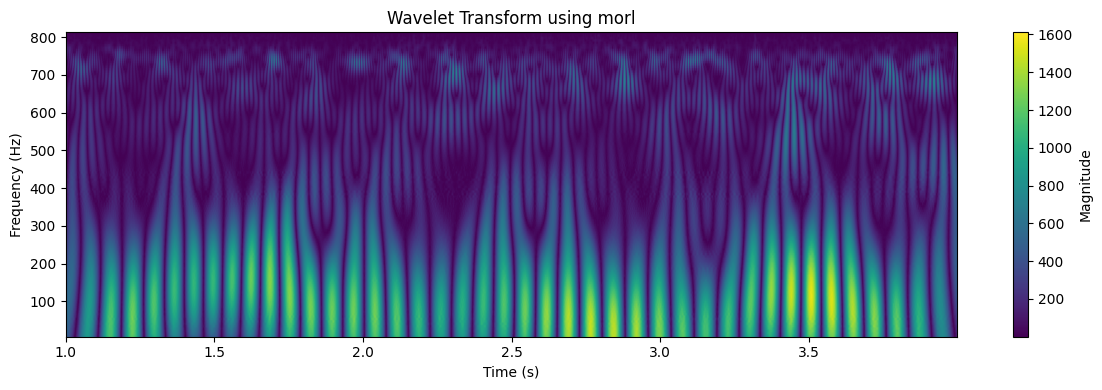

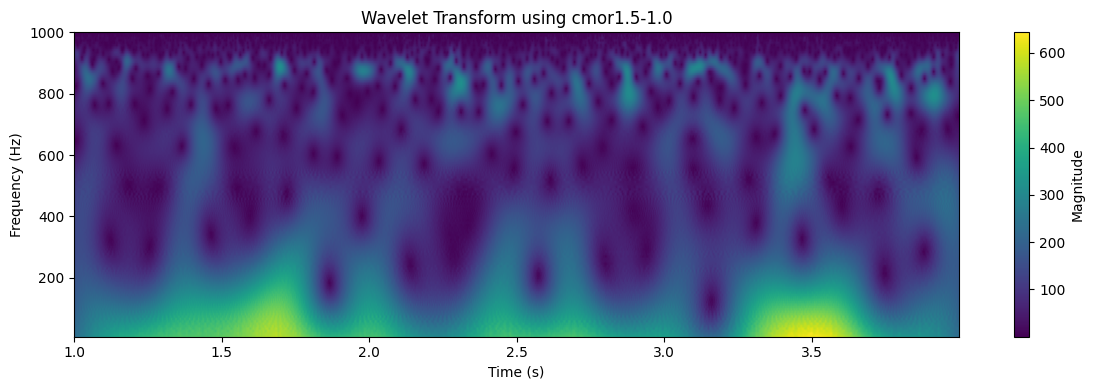

In [44]:
start_time = 1  #in seconds
end_time = 4    #in seconds
start_sample = int(start_time * sampling_rate)
end_sample = int(end_time * sampling_rate)
short_segment = segment[start_sample:end_sample]
short_time = time_array[start_sample:end_sample]

f, t, Sxx = signal.spectrogram(short_segment, sampling_rate)

plt.figure(figsize=(12, 4))
plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')  #log scale for better visibility
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [s]')
plt.title('Spectrogram')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.tight_layout()
plt.show()

wavelets = ['mexh', 'gaus1', 'morl', 'cmor1.5-1.0']
scales = np.arange(1, 128)

for wavelet in wavelets:
    coeffs, _ = pywt.cwt(short_segment, scales, wavelet, sampling_period=1 / sampling_rate)
    freqs = pywt.scale2frequency(wavelet, scales) / (1 / sampling_rate)

    plt.figure(figsize=(12, 4))
    plt.imshow(np.abs(coeffs), extent=[short_time[0], short_time[-1], freqs[-1], freqs[0]],
               cmap='viridis', aspect='auto')
    plt.title(f'Wavelet Transform using {wavelet}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(label='Magnitude')
    plt.tight_layout()
    plt.show()

The transform using the Morlet wavelet shows a sharper and more repetitive pattern in time. The vertical bands are clearer, and the signal's energy appears more focused in certain frequency areas. This suggests that the Morlet wavelet provides better time resolution, it can detect changes in the signal over short periods more accurately.

On the other hand, the complex Morlet transform shows a smoother, more spread-out pattern, especially in the lower frequencies. The energy is less concentrated, and the bands are wider and more blended. This means the complex Morlet wavelet offers better frequency resolution, it can represent the frequency content more precisely, but at the cost of losing some detail about when those frequencies occur in time.

This difference happens because the complex Morlet wavelet is built using both real and imaginary parts, which allows it to capture more information about the frequency and phase of the signal. The regular Morlet wavelet is real and more focused on how the signal changes over time.

In [13]:
pywt.families(short=True)

['haar',
 'db',
 'sym',
 'coif',
 'bior',
 'rbio',
 'dmey',
 'gaus',
 'mexh',
 'morl',
 'cgau',
 'shan',
 'fbsp',
 'cmor']

I guess for gausian is gaus1, instead of gaus

## Exercise 3: REM sleep detection
---
Mammalian sleep is organized in different phases. [Rapid Eye Movement (REM) sleep](https://en.wikipedia.org/wiki/Rapid_eye_movement_sleep) is a well studied phase, with clear markers that make it detectable from LFP data. One of the most used marker is the ratio (or difference) between the oscillatory power in the theta and delta bands in the hippocampus. During REM sleep, the former dominates, in a pattern that resembles active behaviour.  
In this exercise we will use the tools we learned about to detect and inspect the REM and non-REM (nREM) phases of sleep in data recorded from the hippocampus of a sleeping mouse.

- Import the data form `data/moving_lfp.pickle`
- Compute the instantaneous power in the theta (6-10 Hz) and delta (2-4 Hz) frequency bands, for the whole signal.
- z-score the two power signals (subtract the mean and divide by the standard deviation, you can use `scipy.stats.zscore()`)
- Compute and plot the power difference (`theta_power - delta_power`) for the sleep session.
- Compute the REM (power difference $>0.2$) and nREM (power diffewrence $<0.2$) sleep periods.
- Plot examples of REM vs nREM lfp signals (wideband filtered betw. 1 and 200 Hz to get rid of some of the noise).
- Explore how changing the threshold affects the amount of REM sleep detected.

In [38]:
with open('data/sleep_lfp.pickle', 'rb') as handle:
    sleep_lfp_data = pickle.load(handle)

sleep_lfp = sleep_lfp_data['lfp']
sleep_sampling_rate = sleep_lfp_data['sampling_rate']
print(f'Loaded {len(sleep_lfp)/sleep_sampling_rate} seconds of LFP, sampled at {sleep_sampling_rate} Hz')

Loaded 1816.576 seconds of LFP, sampled at 1000.0 Hz


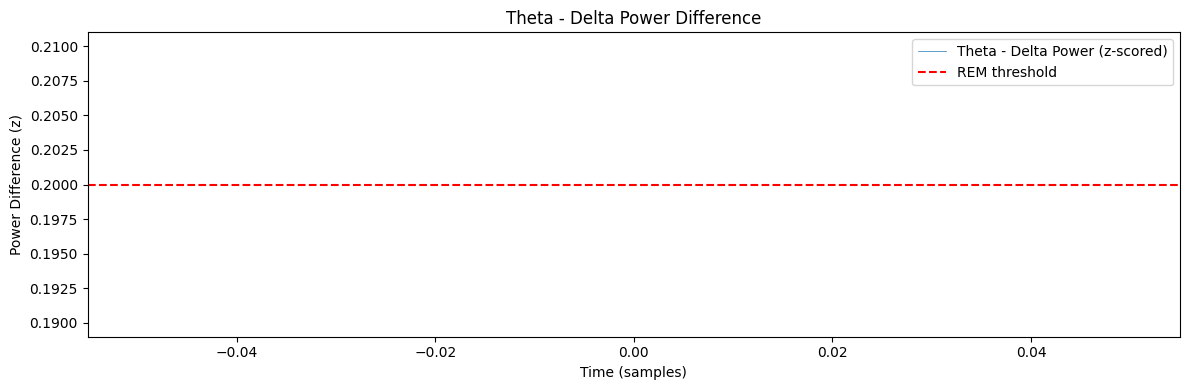

No samples found for REM at current threshold.
No samples found for nREM at current threshold.


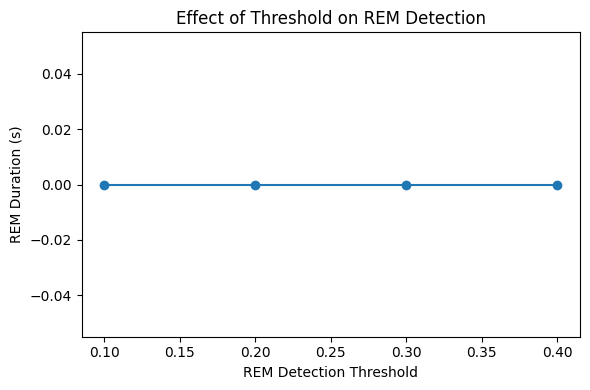

In [42]:
theta_band = bandpass_filter(lfp, 6, 10, sleep_sampling_rate)
delta_band = bandpass_filter(lfp, 2, 4, sleep_sampling_rate)

theta_power = np.abs(signal.hilbert(theta_band))**2
delta_power = np.abs(signal.hilbert(delta_band))**2

theta_power_z = zscore(theta_power)
delta_power_z = zscore(delta_power)

power_diff = theta_power_z - delta_power_z

plt.figure(figsize=(12, 4))
plt.plot(power_diff, label='Theta - Delta Power (z-scored)', linewidth=0.5)
plt.axhline(0.2, color='red', linestyle='--', label='REM threshold')
plt.xlabel('Time (samples)')
plt.ylabel('Power Difference (z)')
plt.legend()
plt.title('Theta - Delta Power Difference')
plt.tight_layout()
plt.show()

rem_indices = np.where(power_diff > 0.2)[0]
nrem_indices = np.where(power_diff <= 0.2)[0]

wideband = bandpass_filter(lfp, 1, 200, sleep_sampling_rate)

def plot_example(indices, label, num_samples=2000):
    if len(indices) == 0:
        print(f"No samples found for {label} at current threshold.")
        return
    idx = indices[len(indices) // 2]
    start = max(0, idx - num_samples // 2)
    end = min(len(wideband), idx + num_samples // 2)
    plt.figure(figsize=(10, 2))
    plt.plot(wideband[start:end])
    plt.title(f'{label} example (centered at sample {idx})')
    plt.xlabel('Time (samples)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.show()


plot_example(rem_indices, 'REM')
plot_example(nrem_indices, 'nREM')

thresholds = [0.1, 0.2, 0.3, 0.4]
durations = []

for t in thresholds:
    rem_duration = len(np.where(power_diff > t)[0]) / sampling_rate
    durations.append(rem_duration)

plt.figure(figsize=(6, 4))
plt.plot(thresholds, durations, marker='o')
plt.xlabel('REM Detection Threshold')
plt.ylabel('REM Duration (s)')
plt.title('Effect of Threshold on REM Detection')
plt.tight_layout()
plt.show()

Yeah, i spent so much time on this exercise and I have no idea anymore where I'm doing wrong.